<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/MYRBM_EBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PART1

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm


# Hyperparameters (adjust these during hyperparameter tuning)
num_epochs = 100
k = 10  # Increased CD-k
num_visible = 784
num_hidden = 1000  # Corrected number of hidden units
learning_rate = 1e-5  # Further lowered learning rate
alpha = 0.01
weight_decay = 1e-3  # Increased weight decay further
momentum = 0.9
clip_value = 1.0
patience = 15  # Increased patience

# Data augmentation transforms (consider simplifying if needed)
transform = transforms.Compose([
    transforms.RandomRotation(5),  # Reduced rotation angle
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Define datasets and dataloaders
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

validation_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False)

# Define the RBM model with dropout
class RBM(nn.Module):
    def __init__(self, num_visible, num_hidden):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(num_hidden, num_visible) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(num_visible))
        self.h_bias = nn.Parameter(torch.zeros(num_hidden))
        self.dropout = nn.Dropout(p=0.5)  # Added dropout layer

    def sample_h(self, v):
        p_h_given_v = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        p_h_given_v = self.dropout(p_h_given_v)  # Apply dropout
        p_h_given_v = torch.clamp(p_h_given_v, 0, 1)  # Clamp the probabilities
        return torch.bernoulli(p_h_given_v)

    def sample_v(self, h):
        p_v_given_h = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))
        return torch.bernoulli(p_v_given_h)

    def energy(self, v, h):
        vWh = torch.matmul(torch.matmul(v, self.W.t()), h.t())
        return -torch.sum(vWh) - torch.matmul(v, self.v_bias) - torch.matmul(h, self.h_bias)

    def forward(self, v, k=1):
        h = self.sample_h(v)
        for _ in range(k):
            v_recon = self.sample_v(h)
            h = self.sample_h(v_recon)
        return v_recon, h

# Define the RBM model
model = RBM(num_visible, num_hidden)

# Define the optimizer with momentum and learning rate scheduling
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)  # Changed to ReduceLROnPlateau

# Define the loss function (consider adding L1 regularization)
def calculate_loss(v, v_recon, model, h):
    reconstruction_loss = torch.mean(model.energy(v, h) - model.energy(v_recon, h))
    regularization_loss = alpha * torch.mean(model.energy(v, h))
    # Add L1 regularization if needed:
    # l1_loss = some_weight * torch.sum(torch.abs(model.W))
    # return reconstruction_loss + regularization_loss + l1_loss
    return reconstruction_loss + regularization_loss

# Training loop with early stopping and gradient clipping
best_val_loss = float('inf')
epochs_without_improvement = 0

train_losses = []  # To store training losses
val_losses = []  # To store validation losses

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            tepoch.set_description(f"Epoch {epoch+1}")
            optimizer.zero_grad()
            data = data.view(data.size(0), -1)
            v_recon, h = model(data, k=k)

            loss = calculate_loss(data, v_recon, model, h)
            epoch_loss += loss.item()

            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()
            tepoch.set_postfix(loss=loss.item())

    scheduler.step(val_loss)  # Update learning rate based on validation loss

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)  # Append training loss
    print(f"Epoch {epoch+1}: Average Training Loss = {avg_epoch_loss:.4f}")

    # Evaluate on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in validation_loader:
            data = data.view(data.size(0), -1)
            v_recon, h = model(data, k=k)
            val_loss += calculate_loss(data, v_recon, model, h).item()
    val_loss /= len(validation_loader)
    val_losses.append(val_loss)  # Append validation loss
    print(f"Epoch {epoch+1}: Validation Loss = {val_loss:.4f}")


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

Epoch 1: 100%|██████████| 938/938 [04:17<00:00,  3.65batch/s, loss=-1.87e+4]


Epoch 1: Average Training Loss = -15371.5073
Epoch 1: Validation Loss = -16250.0142


Epoch 2: 100%|██████████| 938/938 [04:12<00:00,  3.72batch/s, loss=-4.75e+4]


Epoch 2: Average Training Loss = -129640.2592
Epoch 2: Validation Loss = -73062.6465


Epoch 3: 100%|██████████| 938/938 [04:12<00:00,  3.71batch/s, loss=-7.35e+4]


Epoch 3: Average Training Loss = -238585.7736
Epoch 3: Validation Loss = -124395.3875


Epoch 4: 100%|██████████| 938/938 [04:09<00:00,  3.75batch/s, loss=-9.76e+4]


Epoch 4: Average Training Loss = -342716.2692
Epoch 4: Validation Loss = -171438.5087


Epoch 5: 100%|██████████| 938/938 [04:09<00:00,  3.76batch/s, loss=-1.19e+5]


Epoch 5: Average Training Loss = -441749.7569
Epoch 5: Validation Loss = -213710.2039


Epoch 6: 100%|██████████| 938/938 [04:08<00:00,  3.78batch/s, loss=-1.5e+5]


Epoch 6: Average Training Loss = -536288.7771
Epoch 6: Validation Loss = -252294.3734


Epoch 7: 100%|██████████| 938/938 [04:10<00:00,  3.74batch/s, loss=-1.6e+5]


Epoch 7: Average Training Loss = -626584.8465
Epoch 7: Validation Loss = -286698.7974


Epoch 8: 100%|██████████| 938/938 [04:10<00:00,  3.74batch/s, loss=-1.97e+5]


Epoch 8: Average Training Loss = -712570.8576
Epoch 8: Validation Loss = -316965.4693


Epoch 9: 100%|██████████| 938/938 [04:10<00:00,  3.74batch/s, loss=-2.11e+5]


Epoch 9: Average Training Loss = -794977.5020
Epoch 9: Validation Loss = -344576.7710


Epoch 10: 100%|██████████| 938/938 [04:09<00:00,  3.75batch/s, loss=-2.12e+5]


Epoch 10: Average Training Loss = -873685.3222
Epoch 10: Validation Loss = -368937.7947


Epoch 11: 100%|██████████| 938/938 [04:09<00:00,  3.76batch/s, loss=-2.54e+5]


Epoch 11: Average Training Loss = -949199.3262
Epoch 11: Validation Loss = -391368.9312


Epoch 12: 100%|██████████| 938/938 [04:15<00:00,  3.67batch/s, loss=-2.7e+5]


Epoch 12: Average Training Loss = -1021834.4511
Epoch 12: Validation Loss = -409885.0630


Epoch 13: 100%|██████████| 938/938 [04:08<00:00,  3.77batch/s, loss=-2.7e+5]


Epoch 13: Average Training Loss = -1091951.4387
Epoch 13: Validation Loss = -426183.4591


Epoch 14: 100%|██████████| 938/938 [04:08<00:00,  3.77batch/s, loss=-3.03e+5]


Epoch 14: Average Training Loss = -1159061.7863
Epoch 14: Validation Loss = -439995.4295


Epoch 15: 100%|██████████| 938/938 [04:08<00:00,  3.77batch/s, loss=-3.18e+5]


Epoch 15: Average Training Loss = -1224508.5033
Epoch 15: Validation Loss = -450976.5784


Epoch 16: 100%|██████████| 938/938 [04:06<00:00,  3.80batch/s, loss=-3.23e+5]


Epoch 16: Average Training Loss = -1287681.8322
Epoch 16: Validation Loss = -460926.3067


Epoch 17: 100%|██████████| 938/938 [04:07<00:00,  3.80batch/s, loss=-3.27e+5]


Epoch 17: Average Training Loss = -1348222.9004
Epoch 17: Validation Loss = -467513.9681


Epoch 18: 100%|██████████| 938/938 [04:07<00:00,  3.80batch/s, loss=-3.6e+5]


Epoch 18: Average Training Loss = -1407941.7271
Epoch 18: Validation Loss = -471216.3983


Epoch 19: 100%|██████████| 938/938 [04:08<00:00,  3.77batch/s, loss=-3.81e+5]


Epoch 19: Average Training Loss = -1465679.6794
Epoch 19: Validation Loss = -474064.4612


Epoch 20: 100%|██████████| 938/938 [04:06<00:00,  3.80batch/s, loss=-3.87e+5]


Epoch 20: Average Training Loss = -1522750.6519
Epoch 20: Validation Loss = -474832.1180


Epoch 21: 100%|██████████| 938/938 [04:16<00:00,  3.65batch/s, loss=-3.9e+5]


Epoch 21: Average Training Loss = -1577613.2090
Epoch 21: Validation Loss = -473105.3422


Epoch 22: 100%|██████████| 938/938 [04:14<00:00,  3.68batch/s, loss=-4.13e+5]


Epoch 22: Average Training Loss = -1630844.3969
Epoch 22: Validation Loss = -469021.3127


Epoch 23: 100%|██████████| 938/938 [04:13<00:00,  3.70batch/s, loss=-4.26e+5]


Epoch 23: Average Training Loss = -1683490.8763
Epoch 23: Validation Loss = -462908.5919


Epoch 24: 100%|██████████| 938/938 [04:10<00:00,  3.74batch/s, loss=-4.49e+5]


Epoch 24: Average Training Loss = -1735268.7519
Epoch 24: Validation Loss = -454108.4948


Epoch 25: 100%|██████████| 938/938 [04:08<00:00,  3.78batch/s, loss=-4.72e+5]


Epoch 25: Average Training Loss = -1785958.3417
Epoch 25: Validation Loss = -443538.8423


Epoch 26: 100%|██████████| 938/938 [04:06<00:00,  3.81batch/s, loss=-4.48e+5]


Epoch 26: Average Training Loss = -1813181.9842
Epoch 26: Validation Loss = -443389.1630


Epoch 27: 100%|██████████| 938/938 [04:09<00:00,  3.76batch/s, loss=-4.66e+5]


Epoch 27: Average Training Loss = -1818428.7149
Epoch 27: Validation Loss = -441126.1072


Epoch 28: 100%|██████████| 938/938 [04:10<00:00,  3.75batch/s, loss=-4.67e+5]


Epoch 28: Average Training Loss = -1822885.0104
Epoch 28: Validation Loss = -440766.1591


Epoch 29: 100%|██████████| 938/938 [04:05<00:00,  3.82batch/s, loss=-4.52e+5]


Epoch 29: Average Training Loss = -1828741.7261
Epoch 29: Validation Loss = -439803.3270


Epoch 30: 100%|██████████| 938/938 [04:07<00:00,  3.80batch/s, loss=-4.71e+5]


Epoch 30: Average Training Loss = -1830363.9060
Epoch 30: Validation Loss = -438587.2059


Epoch 31: 100%|██████████| 938/938 [04:05<00:00,  3.82batch/s, loss=-4.55e+5]


Epoch 31: Average Training Loss = -1831247.1695
Epoch 31: Validation Loss = -439192.8426


Epoch 32: 100%|██████████| 938/938 [04:05<00:00,  3.83batch/s, loss=-4.55e+5]


Epoch 32: Average Training Loss = -1832107.6725
Epoch 32: Validation Loss = -439675.7077


Epoch 33: 100%|██████████| 938/938 [04:05<00:00,  3.82batch/s, loss=-4.39e+5]


Epoch 33: Average Training Loss = -1832446.5826
Epoch 33: Validation Loss = -439368.6513


Epoch 34: 100%|██████████| 938/938 [04:05<00:00,  3.82batch/s, loss=-4.62e+5]


Epoch 34: Average Training Loss = -1833174.9314
Epoch 34: Validation Loss = -439854.5974


Epoch 35: 100%|██████████| 938/938 [04:08<00:00,  3.78batch/s, loss=-4.6e+5]


Epoch 35: Average Training Loss = -1832971.2019
Epoch 35: Validation Loss = -439252.8702
Early stopping triggered.


<ipython-input-9-8bd1900e690b>:139: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

## PART2

Test Loss: -411018.2771


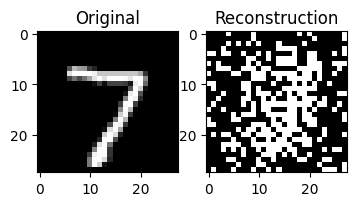

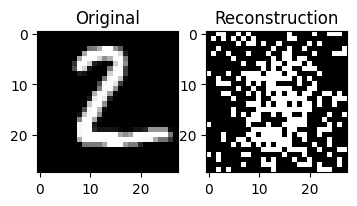

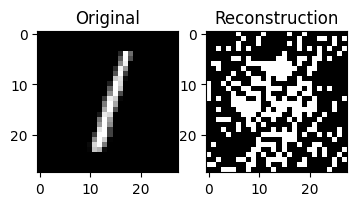

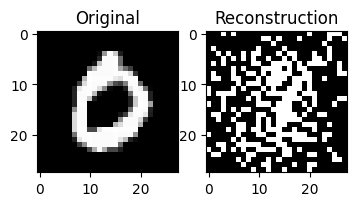

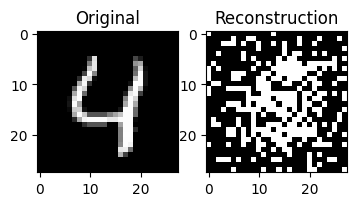

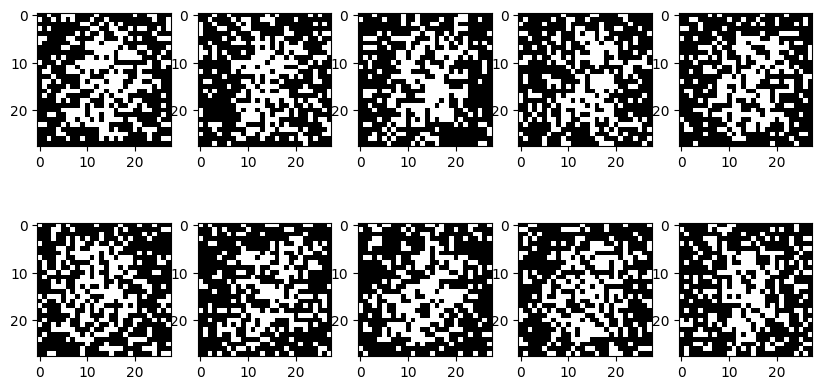

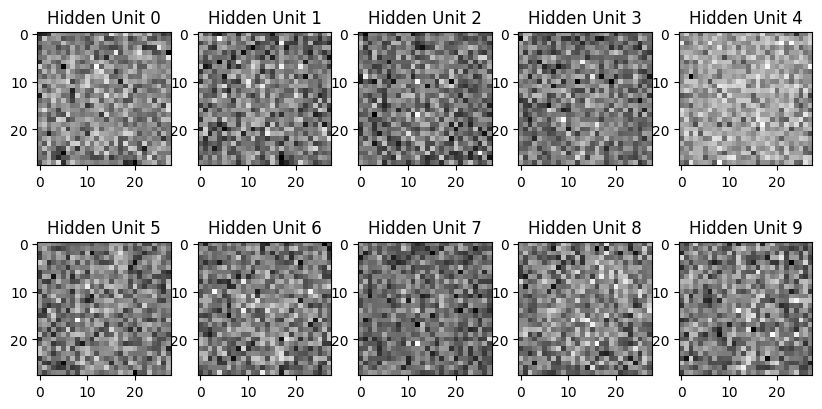

In [10]:
import matplotlib.pyplot as plt

# Evaluate on the test set
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

def evaluate(model, test_loader, k=1):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(data.size(0), -1)
            v_recon, h = model(data, k=k)
            test_loss += calculate_loss(data, v_recon, model, h).item()
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

evaluate(model, test_loader)

# Visualization functions
def visualize_reconstruction(model, data_loader, num_images=5):
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.view(data.size(0), -1)
            v_recon, _ = model(data)
            for i in range(num_images):
                plt.figure(figsize=(4, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(data[i].reshape(28, 28), cmap='gray')
                plt.title('Original')
                plt.subplot(1, 2, 2)
                plt.imshow(v_recon[i].reshape(28, 28), cmap='gray')
                plt.title('Reconstruction')
                plt.show()
            break

def generate_samples(model, num_samples=10, num_steps=100):
    with torch.no_grad():
        v = torch.bernoulli(torch.rand(num_samples, num_visible))
        for _ in range(num_steps):
            h = model.sample_h(v)
            v = model.sample_v(h)
        return v

def visualize_weights(model, num_weights=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_weights):
        plt.subplot(2, 5, i + 1)
        plt.imshow(model.W.detach().numpy()[i].reshape(28, 28), cmap='gray')
        plt.title(f'Hidden Unit {i}')
    plt.show()


# Visualizations
visualize_reconstruction(model, test_loader)
samples = generate_samples(model)
# Visualize the generated samples
plt.figure(figsize=(10, 5))
for i in range(len(samples)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(samples[i].reshape(28, 28), cmap='gray')
plt.show()
visualize_weights(model)
# Visual